### Import packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import merging_functions as mf ### this package included part of the code that are repeated
                                 # throughout to make it more efficient
import matplotlib.pyplot as plt
from shapely import wkt

### Define city and work folder

In [2]:
city='Atlanta'

FIPS = [13057, 13063, 13067, 13089, 13097, 13113, 13121, 13135, 13151, 13247]

folder = 'Output/Atlanta/'

### Load file and convert to pd geodataframe (for visualizing results)

In [3]:
typology_input = pd.read_csv(folder + 'typology_input.csv', index_col = 0) ### Read file
typology_input['geometry'] = typology_input['geometry'].apply(wkt.loads) ### Read geometry as a shp attribute
geo_typology_input  = gpd.GeoDataFrame(typology_input, geometry='geometry') ### Create the gdf
data = geo_typology_input.copy(deep=True)

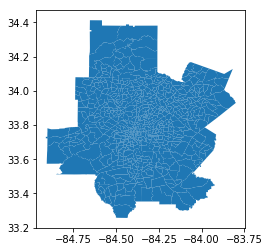

There are 738 census tracts


In [4]:
geo_typology_input.plot()
plt.show()
print ('There are', str(len(geo_typology_input)), 'census tracts')

## Summarize Income Categorization Data

In [5]:
data.groupby('inc_cat_55cut_80120_medhhinc').count()['FIPS']

inc_cat_55cut_80120_medhhinc
1.0    201
2.0     48
4.0    245
5.0     55
6.0    184
Name: FIPS, dtype: int64

In [6]:
data.groupby('inc_cat_55cut_80120_medhhinc_00').count()['FIPS']

inc_cat_55cut_80120_medhhinc_00
2.0     93
4.0    105
5.0     35
6.0    450
Name: FIPS, dtype: int64

## Run Typology Method

### Additional variable treatment

#### Flag for sufficient pop in tract by 2000

In [60]:
### The input file has a flag for 2017 population, but this step will generate the same flag for 2000
data['pop00flag'] = np.where((data['pop_00'] >500), 1, 0)

POPULATION OVER 500 FOR YEAR 2000


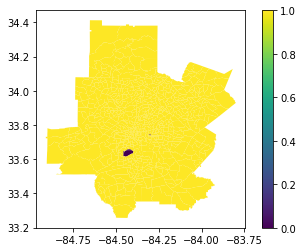

There are  3 census tract with pop<500 in 2000


In [61]:
print('POPULATION OVER 500 FOR YEAR 2000')
ax = data.plot(color = 'white')
ax = data.plot(ax = ax, column = 'pop00flag', legend = True)
plt.show()
print('There are ', len(data[data['pop00flag']==0]), 'census tract with pop<500 in 2000')

#### LI migration change
Percentage point - this is change from the 10 data, not the 2000 data because it didn't exist then

per_limove_XX = Percentage of people who moved into a tract in the last 5 years who are LI (20XX)

In [62]:
### Percentage point change in low income movers 10-17
data['ppt_ch_li_movein_10_17'] = data['per_limove_17'] - data['per_limove_10']
data[['per_limove_17', 'per_limove_10', 'ppt_ch_li_movein_10_17']].head()

,per_limove_17,per_limove_10,ppt_ch_li_movein_10_17
0,0.803105,0.608537,0.194567
1,0.712235,0.726232,-0.013997
2,0.639516,0.663437,-0.023921
3,0.711062,0.843743,-0.132681
4,0.433714,0.441921,-0.008207


PERCENT POINT CHANGE IN LOW INCOME MOVERS 2010-2017


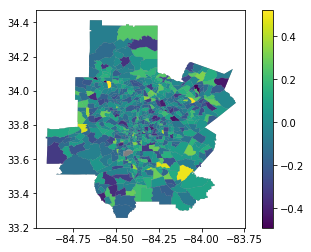

There are  4 census tract with NaN data


In [63]:
print('PERCENT POINT CHANGE IN LOW INCOME MOVERS 2010-2017')
ax = data.plot(color = 'grey')
ax = data[~data['ppt_ch_li_movein_10_17'].isna()].plot(ax = ax, column = 'ppt_ch_li_movein_10_17', legend = True)
plt.show()
print('There are ', len(data[data['ppt_ch_li_movein_10_17'].isna()]), 'census tract with NaN data')

#### Change in variables 2000 to 2017

In [64]:
list(data.columns)

['FIPS',
 'COUNTYFP',
 'geometry',
 'real_hinc_90',
 'real_hinc_00',
 'hinc_17',
 'regmedian_income90',
 'vli_90',
 'li_90',
 'mi1990',
 'hmi1990',
 'hi1990',
 'vhi1990',
 'vli_00',
 'li_00',
 'mi2000',
 'hmi2000',
 'hi2000',
 'vhi2000',
 'vli_17',
 'li_17',
 'mi2017',
 'hmi2017',
 'hi2017',
 'vhi2017',
 'pop_17',
 'pop_17_se',
 'nhwhite_17',
 'hh_17',
 'hinc_17_se',
 'hu_17',
 'ohu_17',
 'rhu_17',
 'hu_17_se',
 'rhu_17_se',
 'mrent_17',
 'mrent_17_se',
 'mhval_17',
 'mhval_17_se',
 'per_nonwhite_17',
 'per_nhblk_17',
 'per_hisp_17',
 'per_asian_17',
 'col_17',
 'per_col_17',
 'per_carcommute_17',
 'hhwchild_17',
 'per_hhwchild_17',
 'per_rent_17',
 'per_units_pre50_17',
 'per_built_00_17',
 'per_rent_17_se',
 'col_17_se',
 'per_col_17_se',
 'pop_00',
 'nhwhite_00',
 'nhblk_00',
 'asian_00',
 'hisp_00',
 'hu_00',
 'ohu_00',
 'rhu_00',
 'per_nonwhite_00',
 'per_nhblk_00',
 'per_hisp_00',
 'per_asian_00',
 'col_00',
 'per_col_00',
 'per_carcommute_00',
 'hh_00',
 'per_rent_00',
 'pop_90'

In [65]:
### This should be recoded to eliminate infinite values 
variables = ['pop', 'per_col', 'real_mhval', 'real_mrent', 'all_li_count', 'per_all_li', 'real_hinc']
# pop per_col real_mhval real_mrent all_li_count per_all_li real_hinc

var_17 = list()
var_00 = list()
for i in variables:
    name_17 = i+'_17'
    var_17.append(name_17)
    name_00 = i+'_00'
    var_00.append(name_00)
    data['ch_'+i+'_00_17'] = data[name_17] - data[name_00]
    data['pctch_'+i+'_00_17'] = data['ch_'+i+'_00_17']/data[name_00]

In [66]:
data[var_17].describe()

,pop_17,per_col_17,real_mhval_17,real_mrent_17,all_li_count_17,per_all_li_17,real_hinc_17
count,738.000000,735.000000,7.200000e+02,722.000000,733.000000,733.000000,733.000000
mean,6018.975610,0.397915,2.160976e+05,1187.326870,868.947407,0.424315,67177.731241
std,3088.912066,0.209159,1.423736e+05,343.964592,501.224375,0.194857,32606.820104
min,0.000000,0.015365,1.050000e+04,335.000000,64.555227,0.049430,9815.000000
25%,3985.750000,0.232944,1.153000e+05,964.250000,497.420254,0.271603,43321.000000
50%,5490.500000,0.345016,1.754000e+05,1125.000000,794.931003,0.395853,62222.000000
75%,7540.250000,0.555854,2.729500e+05,1329.750000,1145.082948,0.569462,82953.000000
max,24632.000000,0.876223,1.117200e+06,3501.000000,3845.635247,1.000000,200179.000000


In [67]:
data[var_00].describe()

,pop_00,per_col_00,real_mhval_00,real_mrent_00,all_li_count_00,per_all_li_00,real_hinc_00
count,738.000000,736.000000,7.380000e+02,738.000000,736.000000,736.000000,738.000000
mean,4647.198845,0.338896,1.569088e+05,817.945041,402.385812,0.250609,58522.807860
std,1599.885943,0.193963,1.161577e+05,396.011244,255.463375,0.167389,33819.652595
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3562.604832,0.181872,8.670313e+04,515.615482,205.695161,0.127083,33690.284764
50%,4620.094827,0.304576,1.300480e+05,793.055666,345.991408,0.212353,51760.103778
75%,5763.206454,0.484605,1.875518e+05,1074.595273,539.732774,0.325565,75592.985413
max,7997.000000,0.839497,1.394081e+06,2788.931516,1396.358728,0.930889,235732.681013


In [68]:
var_ch = list()
var_pctch = list()
for i in variables:
    name_ch = 'ch_'+i+'_00_17'
    var_ch.append(name_ch)
    name_pctch = 'pctch_'+i+'_00_17'
    var_pctch.append(name_pctch)

In [69]:
data[var_ch].describe()

,ch_pop_00_17,ch_per_col_00_17,ch_real_mhval_00_17,ch_real_mrent_00_17,ch_all_li_count_00_17,ch_per_all_li_00_17,ch_real_hinc_00_17
count,738.000000,735.000000,7.200000e+02,722.000000,733.000000,733.000000,733.000000
mean,1371.776765,0.058963,5.708158e+04,368.389133,465.255652,0.173667,8453.783393
std,2354.580167,0.101138,1.168136e+05,464.666605,420.564889,0.130128,32364.453416
min,-2625.000000,-0.234620,-1.157481e+06,-1219.931516,-432.047808,-0.327410,-64800.656314
25%,63.500000,-0.004523,-1.424729e+04,7.681550,182.368165,0.091967,-14901.949734
50%,731.490407,0.052737,3.400764e+04,274.777909,393.121539,0.169256,1725.253267
75%,1889.335240,0.111638,1.009882e+05,683.178519,668.596679,0.261849,28036.699540
max,16915.370003,0.497677,7.390341e+05,2532.369971,3175.646039,0.628433,163927.360282


In [70]:
data[var_pctch].describe()

,pctch_pop_00_17,pctch_per_col_00_17,pctch_real_mhval_00_17,pctch_real_mrent_00_17,pctch_all_li_count_00_17,pctch_per_all_li_00_17,pctch_real_hinc_00_17
count,736.000000,735.000000,720.000000,722.000000,733.000000,733.000000,733.000000
mean,0.300995,inf,0.695989,0.892352,1.635124,1.030239,0.457664
std,0.513059,NaN,1.381406,1.427879,1.668482,0.876710,1.175512
min,-1.000000,-0.800595,-0.830283,-0.505061,-0.790099,-0.484229,-0.656954
25%,0.016886,-0.012773,-0.103991,0.004852,0.547384,0.406012,-0.215314
50%,0.161578,0.152688,0.198576,0.334086,1.265246,0.891157,0.039024
75%,0.441661,0.442924,1.003307,1.283611,2.183096,1.467908,0.716861
max,4.648946,inf,12.820128,11.811215,16.629402,6.571595,11.681080


In [71]:
data[['FIPS', 'pctch_per_col_00_17']][data['pctch_per_col_00_17']==np.inf]

,FIPS,pctch_per_col_00_17
25,13121006802,inf
128,13121004400,inf


In [72]:
data[['FIPS', 'pctch_real_mhval_00_17']][data['pctch_real_mhval_00_17']==np.inf]

,FIPS,pctch_real_mhval_00_17


In [73]:
data[['FIPS', 'pctch_real_mrent_00_17']][data['pctch_real_mrent_00_17']==np.inf]

,FIPS,pctch_real_mrent_00_17


#### Change in variables 1990 to 2000

In [74]:
variables = ['pop', 'per_col', 'real_mhval', 'real_mrent', 'all_li_count', 'per_all_li', 'real_hinc']

var_90 = list()
var_00 = list()
for i in variables:
    name_90 = i+'_90'
    var_90.append(name_90)
    name_00 = i+'_00'
    data['ch_'+i+'_90_00'] = data[name_00] - data[name_90]
    data['pctch_'+i+'_90_00'] = data['ch_'+i+'_90_00']/data[name_90]

#### Variables to be compared to regional median

In [75]:
variables = ['mrent_90', 'real_mhval_90', 'real_mhval_00', 'per_all_li_90', 'per_nonwhite_90',
             'per_rent_90', 'per_col_90', 'per_col_17', 'ch_per_col_90_00', 'ch_per_col_00_17',
             'per_rent_17', 'per_nonwhite_17', 'per_all_li_17', 'pctch_real_mhval_90_00', 'pctch_real_mhval_00_17',
             'pctch_real_mrent_90_00', 'pctch_real_mrent_00_17', 'per_limove_10', 'per_limove_17', 'ppt_ch_li_movein_10_17',
             'per_units_pre50_17', 'pctch_real_hinc_90_00', 'pctch_real_hinc_00_17', 'mrent_00', 'per_all_li_00',
             'per_rent_00', 'per_nonwhite_00', 'per_col_00', 'empd_17', 'per_built_00_17',  'density_17', 'per_nhblk_17',
             'per_asian_17', 'per_hisp_17']

var_name = list()
var_median = list()

rm_variables={}
for i in variables:
    ### Creates variable names
    name = 'rm_'+i
    var_name.append(name)
    
    ### Computes variable median, ignores NaN data
    median = np.nanmedian(data[i])
    var_median.append(median)
    
    ### Adds it to the data dictionary for future reference
    rm_variables[name] = median

    ### Checks whether value is above regional median
    data['aboverm_'+i] = np.where(data[i]>=rm_variables[name], 1, 0)
    data['aboverm_'+i] = np.where(data[i].isna(), np.nan, data['aboverm_'+i])

rm_variables

{'rm_mrent_90': 268.11292575549277,
 'rm_real_mhval_90': 77223.05253503652,
 'rm_real_mhval_00': 130047.9518054459,
 'rm_per_all_li_90': 0.10370992700000001,
 'rm_per_nonwhite_90': 0.14379415,
 'rm_per_rent_90': 0.33617023,
 'rm_per_col_90': 0.26028581,
 'rm_per_col_17': 0.34501609999999994,
 'rm_ch_per_col_90_00': 0.05252843499999999,
 'rm_ch_per_col_00_17': 0.05273726000000001,
 'rm_per_rent_17': 0.3791363,
 'rm_per_nonwhite_17': 0.6118584,
 'rm_per_all_li_17': 0.395853,
 'rm_pctch_real_mhval_90_00': 0.5426234285553099,
 'rm_pctch_real_mhval_00_17': 0.19857609885441585,
 'rm_pctch_real_mrent_90_00': 0.37078514039876487,
 'rm_pctch_real_mrent_00_17': 0.33408584008214876,
 'rm_per_limove_10': 0.49559754,
 'rm_per_limove_17': 0.45330834,
 'rm_ppt_ch_li_movein_10_17': -0.038419780000000014,
 'rm_per_units_pre50_17': 0.015625,
 'rm_pctch_real_hinc_90_00': 0.46343040385931916,
 'rm_pctch_real_hinc_00_17': 0.03902370903025677,
 'rm_mrent_00': 569.0008444966061,
 'rm_per_all_li_00': 0.212353

In [76]:
### Checks that code is running properly with one example
variable = 'pctch_real_mrent_00_17'
print(rm_variables['rm_'+variable])
data[[variable, 'aboverm_'+variable]].head(10)

# data[data[variable].isna()][[variable, 'aboverm_'+variable]].head()

0.33408584008214876


,pctch_real_mrent_00_17,aboverm_pctch_real_mrent_00_17
0,1.430023,1.0
1,-0.081359,0.0
2,0.771917,1.0
3,3.889998,1.0
4,5.130423,1.0
5,1.578677,1.0
6,-0.007091,0.0
7,0.786447,1.0
8,-0.039521,0.0
9,0.051653,0.0


#### Loss of LI HH

In [77]:
data['ch_all_li_count_00_17'].isna().sum()

5

In [78]:
### Computes loss of LI HH - This needs to be double checked for missing values, because there are only zeroes
data['lostli_17'] = np.where((data['ch_all_li_count_00_17']<0)&(~data['ch_all_li_count_00_17'].isna()), 1, 0)
data['lostli_17'] = np.where((data['ch_all_li_count_00_17'].isna()), np.nan, data['lostli_17'])
data['lostli_00'] = np.where((data['ch_all_li_count_90_00']<0)&(~data['ch_all_li_count_90_00'].isna()), 1, 0)
data['lostli_00'] = np.where((data['ch_all_li_count_90_00'].isna()), np.nan, data['lostli_00'])

LOSS OF LI HH 2000-2017


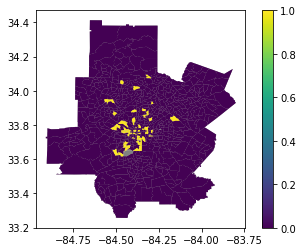

There are  5 census tract with NaN as data


In [79]:
print('LOSS OF LI HH 2000-2017')
ax = data.plot(color = 'grey')
ax = data[~data['lostli_17'].isna()].plot(ax = ax, column = 'lostli_17', legend = True)
plt.show()
print('There are ', data['lostli_17'].isna().sum(), 'census tract with NaN as data')

LOSS OF LI HH 1990-2000


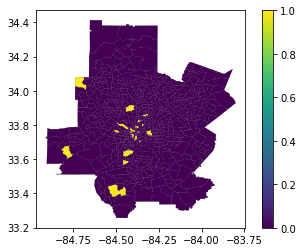

There are  2 census tract with NaN as data


In [80]:
print('LOSS OF LI HH 1990-2000')
ax = data.plot(color = 'grey')
ax = data[~data['lostli_00'].isna()].plot(ax = ax, column = 'lostli_00', legend = True)
plt.show()
print('There are ', data['lostli_00'].isna().sum(), 'census tract with NaN as data')

### Vulnerability to Gentrification

In [81]:
### Vulnerable to gentrification index, for both '90 and '00 - make it a flag

### ***** 1990 *****
### 2/4 Criteria that needs to be met
data['vul90_1'] = data['aboverm_per_all_li_90'] + data['aboverm_per_nonwhite_90'] + data['aboverm_per_rent_90']
data['vul90_2'] = np.where(data['aboverm_per_col_90']==0, 1, 0) ### This is the opposite criteria. Where flag = 0
data['vul90'] = data['vul90_1'] + data['vul90_2'] ### 2/4 of these criteria need to be met - This is included in vul_gent_90
data['vul90'] = np.where((data['per_all_li_90'].isna())|
                         (data['per_all_li_90'].isna())|
                         (data['per_all_li_90'].isna())|
                         (data['per_all_li_90'].isna()), np.nan, data['vul90'])

data['vul_gent_90'] = np.where(((data['mrent_90']<rm_variables['rm_mrent_90'])|(data['aboverm_real_mhval_90']==0))&
                               (data['vul90']>1)&(~data['vul90'].isna()), 1, 0)
data['vul_gent_90'] = np.where((data['mrent_90'].isna())|
                               (data['aboverm_real_mhval_90'].isna()), np.nan, data['vul_gent_90'])

### ***** 2000 *****
### 2/4 Criteria that needs to be met
data['vul00_1'] = data['aboverm_per_all_li_00'] + data['aboverm_per_nonwhite_00'] + data['aboverm_per_rent_00']
data['vul00_2'] = np.where(data['aboverm_per_col_00']==0, 1, 0) ### This is the opposite criteria. Where flag = 0
data['vul00'] = data['vul00_1'] + data['vul00_2'] ### 2/4 of these criteria need to be met - This is included in vul_gent_90
data['vul00'] = np.where((data['per_all_li_00'].isna())|
                         (data['per_all_li_00'].isna())|
                         (data['per_all_li_00'].isna())|
                         (data['per_all_li_00'].isna()), np.nan, data['vul00'])

data['vul_gent_00'] = np.where(((data['mrent_00']<rm_variables['rm_mrent_00'])|(data['aboverm_real_mhval_00']==0))&
                               (data['vul00']>1)&(~data['vul00'].isna()), 1, 0)
data['vul_gent_00'] = np.where((data['mrent_00'].isna())|
                               (data['aboverm_real_mhval_00'].isna()), np.nan, data['vul_gent_00'])

In [82]:
print(data['vul_gent_90'].describe())
print(data['vul_gent_00'].describe())

count    738.000000
mean       0.330623
std        0.470757
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: vul_gent_90, dtype: float64
count    738.000000
mean       0.397019
std        0.489612
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: vul_gent_00, dtype: float64


VULNERABLE IN 1990


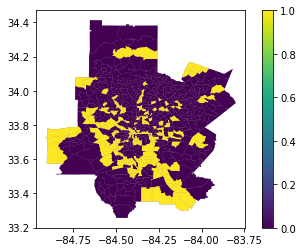

There are  0 census tract with NaN as data
There are  244 vulnerable to gentrification in 1990


In [85]:
print('VULNERABLE IN 1990')
ax = data.plot(color = 'grey')
ax = data[~data['vul_gent_90'].isna()].plot(ax = ax, column = 'vul_gent_90', legend = True)
plt.show()
print('There are ', data['vul_gent_90'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vul_gent_90']==1).sum(), 'vulnerable to gentrification in 1990')

VULNERABLE IN 2000


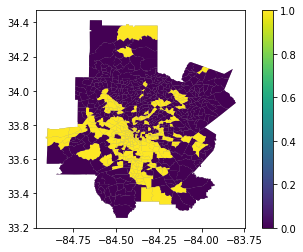

There are  0 census tract with NaN as data
There are  293 vulnerable to gentrification in 2000


In [87]:
print('VULNERABLE IN 2000')
ax = data.plot(color = 'grey')
ax = data[~data['vul_gent_00'].isna()].plot(ax = ax, column = 'vul_gent_00', legend = True)
plt.show()
print('There are ', data['vul_gent_00'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vul_gent_00']==1).sum(), 'vulnerable to gentrification in 2000')

###### Out of curiosity

In [88]:
### Out of curiosity
data['vulnerable'] = data['vul_gent_90']*data['vul_gent_00']

VULNERABLE IN BOTH YEARS


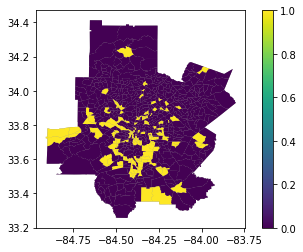

There are  0 census tract with NaN as data
There are  167 census tracts vulnerable in both years


In [89]:
print('VULNERABLE IN BOTH YEARS')
ax = data.plot(color = 'grey')
ax = data[~data['vulnerable'].isna()].plot(ax = ax, column = 'vulnerable', legend = True)
plt.show()
print('There are ', data['vulnerable'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vulnerable']==1).sum(), 'census tracts vulnerable in both years')

### Hot Market

In [90]:
### Hot market in '00 and '17 - make it a flag:
### Using old methodology for now, will update later
### New methodology would be rapid increase (2013-2017)

data['hotmarket_17'] = np.where((data['aboverm_pctch_real_mhval_00_17']==1)|
                                (data['aboverm_pctch_real_mrent_00_17']==1), 1, 0)
data['hotmarket_17'] = np.where((data['aboverm_pctch_real_mhval_00_17'].isna())&
                                (data['aboverm_pctch_real_mrent_00_17'].isna()),np.nan,data['hotmarket_17'])

data['hotmarket_00'] = np.where((data['aboverm_pctch_real_mhval_90_00']==1)|
                                (data['aboverm_pctch_real_mrent_90_00']==1), 1, 0)
data['hotmarket_00'] = np.where((data['aboverm_pctch_real_mhval_90_00'].isna())&
                                (data['aboverm_pctch_real_mrent_90_00'].isna()),np.nan,data['hotmarket_00'])

In [91]:
print(data['hotmarket_17'].describe())
data.groupby('hotmarket_17').count()['FIPS']

count    733.000000
mean       0.585266
std        0.493012
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: hotmarket_17, dtype: float64


hotmarket_17
0.0    304
1.0    429
Name: FIPS, dtype: int64

In [92]:
print(data['hotmarket_00'].describe())
data.groupby('hotmarket_00').count()['FIPS']

count    736.000000
mean       0.557065
std        0.497071
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: hotmarket_00, dtype: float64


hotmarket_00
0.0    326
1.0    410
Name: FIPS, dtype: int64

HOT MARKET 2017


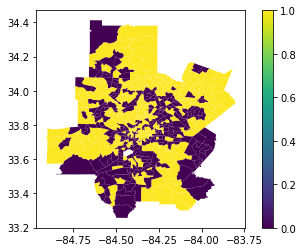

There are  5 census tract with NaN as data
There are  167 census tracts with hot market in 2017


In [95]:
print('HOT MARKET 2017')
ax = data.plot(color = 'white')
ax = data[~data['hotmarket_17'].isna()].plot(ax = ax, column = 'hotmarket_17', legend = True)
plt.show()
print('There are ', data['hotmarket_17'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vulnerable']==1).sum(), 'census tracts with hot market in 2017')

HOT MARKET 2000


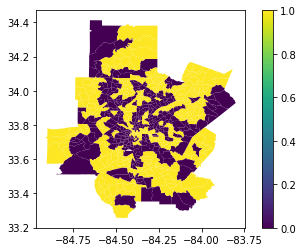

There are  2 census tracts with hot market in 2000


In [96]:
print('HOT MARKET 2000')
ax = data.plot(color = 'white')
ax = data[~data['hotmarket_00'].isna()].plot(ax = ax, column = 'hotmarket_00', legend = True)
plt.show()
print('There are ', data['hotmarket_00'].isna().sum(), 'census tracts with hot market in 2000')

### Gentrification

In [97]:
### 1990 - 2000

### Computes how many criteria are met
data['gent_90'] = data['aboverm_ch_per_col_90_00']+data['aboverm_pctch_real_hinc_90_00']+data['lostli_00']

### Creates the dummy - if it meets more than 1 -> 1
data['gent_90_dem'] = np.where(data['gent_90']>=2, 1, 0)
data['gent_90_dem'] = np.where((data['aboverm_ch_per_col_90_00'].isna())|
                               (data['aboverm_pctch_real_hinc_90_00'].isna())|
                               (data['lostli_00'].isna()), np.nan, data['gent_90_dem'])

### Make the overall gentrification variable
data['gent_90_00'] = np.where((data['vul_gent_90']==1)&
                              (data['gent_90_dem']==1)&
                              (data['hotmarket_00']==1), 1, 0)
data['gent_90_00'] = np.where((data['vul_gent_90'].isna())|
                               (data['gent_90_dem'].isna())|
                               (data['hotmarket_00'].isna()), np.nan, data['gent_90_00'])



# 2000 - 2017

### Computes how many criteria are met
data['gent_00'] = data['aboverm_ch_per_col_00_17']+data['aboverm_pctch_real_hinc_00_17']+data['lostli_17']

### Creates the dummy - if it meets more than 1 -> 1
data['gent_00_dem'] = np.where(data['gent_00']>=2, 1, 0)
data['gent_00_dem'] = np.where((data['aboverm_ch_per_col_00_17'].isna())|
                               (data['aboverm_pctch_real_hinc_00_17'].isna())|
                               (data['lostli_00'].isna()), np.nan, data['gent_00_dem'])

### Make the overall gentrification variable
data['gent_00_17'] = np.where((data['vul_gent_00']==1)&
                              (data['gent_00_dem']==1)&
                              (data['per_limove_17']<data['per_limove_10'])& ### Should this be 2009??
                              (data['hotmarket_17']==1), 1, 0)
data['gent_00_17'] = np.where((data['vul_gent_00'].isna())|
                               (data['gent_00_dem'].isna())|
                               (data['per_limove_17'].isna())|
                               (data['per_limove_10'].isna())|
                               (data['hotmarket_17'].isna()), np.nan, data['gent_00_17'])

In [98]:
data[['FIPS', 'vul_gent_00', 'gent_00_dem', 'per_limove_17', 'per_limove_10', 'hotmarket_00']].describe()

,FIPS,vul_gent_00,gent_00_dem,per_limove_17,per_limove_10,hotmarket_00
count,7.380000e+02,738.000000,733.000000,735.000000,734.000000,736.000000
mean,1.310464e+10,0.397019,0.302865,0.465407,0.496696,0.557065
std,3.436242e+07,0.489612,0.459811,0.179222,0.186238,0.497071
min,1.305709e+10,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.306703e+10,0.000000,0.000000,0.338553,0.364677,0.000000
50%,1.311314e+10,0.000000,0.000000,0.453308,0.495598,1.000000
75%,1.312101e+10,1.000000,1.000000,0.589968,0.626413,1.000000
max,1.324706e+10,1.000000,1.000000,0.972915,1.000000,1.000000


GENTRIFICATION 1990 - 2000


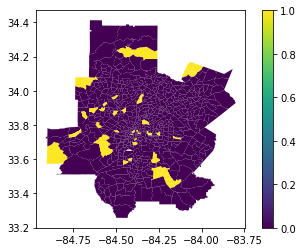

There are  2 census tract with NaN as data
58 census tracts were gentrified 1990-2000


In [99]:
print('GENTRIFICATION 1990 - 2000')
ax = data.plot(color = 'white')
ax = data[~data['gent_90_00'].isna()].plot(ax = ax, column = 'gent_90_00', legend = True)
plt.show()
print('There are ', data['gent_90_00'].isna().sum(), 'census tract with NaN as data')
print(str((data['gent_90_00']==1).sum()), 'census tracts were gentrified 1990-2000')

GENTRIFICATION 2000 - 2017


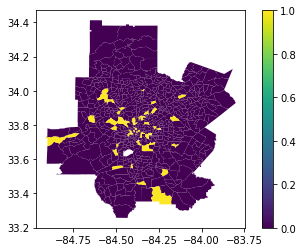

There are  6 census tract with NaN as data
63 census tracts were gentrified 2000-2017


In [100]:
print('GENTRIFICATION 2000 - 2017')
ax = data.plot(color = 'white')
ax = data[~data['gent_00_17'].isna()].plot(ax = ax, column = 'gent_00_17', legend = True)
plt.show()
print('There are ', data['gent_00_17'].isna().sum(), 'census tract with NaN as data')
print(str((data['gent_00_17']==1).sum()), 'census tracts were gentrified 2000-2017')

In [101]:
(data['gent_00_17']*data['gent_90_00']).sum()

6.0

### Typology definitions

Make flags for each typology definition - goal is to make them flags so we can compare accross typologies to check if any are being double counted or missed. Note on missing data: will code it so that the typology is missing if any of the core data elements are missing, but for any additional risk or stability criteria, will be coded so that it pulls from a shorter list if any are missing so as not to throw it all out


#### At Risk of Gentrification

In [102]:
df = data
### ************* At risk of gentrification **************

df['ARG_risks'] = df['aboverm_per_units_pre50_17'] + df['ab_90percentile_ch'] +\
                  df['exclusive_tract'] + df['rail'] + df['anchor_institution']

### Zillow increase flag - only above 90 perentile increase used

df['ARG_risks_missings'] = np.nan
df['ARG_risks_missings'] = (df['aboverm_per_units_pre50_17'].isna().astype('int'))+ \
                                (df['ab_90percentile_ch'].isna().astype('int'))+ \
                                (df['exclusive_tract'].isna().astype('int'))+ \
                                (df['rail'].isna().astype('int'))+ \
                                (df['anchor_institution'].isna().astype('int'))

# print(df.groupby('OD_instability_missings').count()['FIPS']) ### Summarizes how many FIPS have missing data

### This seems like a weird way to code the data
df['ARG_risks'] = np.where((df['ARG_risks_missings']==3)|
                           (df['ARG_risks_missings']==4)|
                           (df['ARG_risks_missings']==5), np.nan, df['ARG_risks'])

### I think these should be >=2 OR >3
df['ARG_risks'] = np.where((df['ARG_risks_missings']==2)|(df['ARG_risks']>=2), 1, df['ARG_risks'])
df['ARG_risks'] = np.where((df['ARG_risks_missings']==1)|(df['ARG_risks']==1), 0, df['ARG_risks'])
df['ARG_risks'] = np.where((df['ARG_risks_missings']==1)|(df['ARG_risks']>=2), 1, df['ARG_risks'])
df['ARG_risks'] = np.where((df['ARG_risks_missings']==0)|(df['ARG_risks']==1), 0, df['ARG_risks'])
df['ARG_risks'] = np.where((df['ARG_risks_missings']==0)|(df['ARG_risks']>=2), 1, df['ARG_risks'])

### ****ARG ****
df['ARG'] = 0
df['ARG'] = np.where((df['pop00flag']==1)&
                    ((df['low_pdmt_55cut_80120_medhhinc']==1)|(df['mix_low_55cut_80120_medhhinc']==1))&
                    ((df['lmh_flag_new_encoded']==1)|(df['lmh_flag_new_encoded']==2))&
                    ((df['aff_change_cat_full_encoded'] == 2)|(df['aff_change_cat_full_encoded'] == 3)|
                     (df['aff_change_cat_full_encoded'] == 6)|(df['aff_change_cat_full_encoded'] == 7))&
                     (df['gent_90_00']==0)&
                     (df['gent_00_17']==0)&
                     (df['ARG_risks']==1), 1, 0)

df['ARG'] = np.where((df['pop00flag'].isna())|
                     (df['low_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['mix_low_55cut_80120_medhhinc'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['aff_change_cat_full_encoded'].isna())|
                     (df['gent_90_00'].isna())|
                     (df['gent_00_17'].isna())|
                     (df['ARG_risks'].isna()), np.nan, df['ARG'])

AT RISK OF GENTRIFICATION


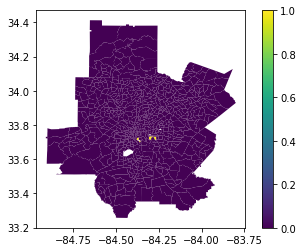

There are  6 census tract with NaN as data
There are  4 At Risk of Gentrification CT


In [103]:
print('AT RISK OF GENTRIFICATION')
ax = data.plot(color = 'white')
ax = data[~data['ARG'].isna()].plot(ax = ax, column = 'ARG', legend = True)
plt.show()
print('There are ', data['ARG'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['ARG']==1).sum()), 'At Risk of Gentrification CT')

#### Ongoing Displacement

In [104]:
### Include a "churn" and a "hollowing-out/loss" version to examine
df = data

# gen OD_churn=0
# gen OD_loss=0

### Start with coding OD instability criteria variables
# For this, essentially add up the flagged variables, then can exclude those that don't meet enough criteria
# Note: this is accounting for missingness, see notes documentation in "notes" folder

### Stability Criteria
### Low access to capital
df['low_capital_access'] = np.where((df['low_app_rate'] == 1)|(df['high_denialrate20'] ==1), 1, 0)
df['low_capital_access'] = np.where((df['low_app_rate'].isna())|
                                    (df['high_denialrate20'].isna()), np.nan, data['low_capital_access'])

df['OD_instability_1'] = df['aboverm_foreclosurerate'] + df['vacancy_rm_flag'] + df['low_capital_access']
df['OD_instability_0'] = np.where(df['aboverm_homeownership_LItracts'] == 0, 1, 0)
df['OD_instability'] = df['OD_instability_1'] + df['OD_instability_0']

df['OD_instability_missings'] = (df['aboverm_foreclosurerate'].isna().astype('int'))+ \
                                (df['vacancy_rm_flag'].isna().astype('int'))+ \
                                (df['low_capital_access'].isna().astype('int'))+ \
                                (df['aboverm_homeownership_LItracts'].isna().astype('int'))

print(df.groupby('OD_instability_missings').count()['FIPS']) ### Summarizes how many FIPS have missing data

### This seems like a weird way to code the data
df['OD_instability'] = np.where((df['OD_instability_missings']==3)|(df['OD_instability_missings']==4), np.nan, df['OD_instability'])
df['OD_instability'] = np.where((df['OD_instability_missings']==2)|(df['OD_instability']==2), 1, df['OD_instability'])
df['OD_instability'] = np.where((df['OD_instability_missings']==1)|(df['OD_instability']<2), 0, df['OD_instability'])
df['OD_instability'] = np.where((df['OD_instability_missings']==1)|(df['OD_instability']>=2), 1, df['OD_instability'])
df['OD_instability'] = np.where((df['OD_instability_missings']==0)|(df['OD_instability']<2), 0, df['OD_instability'])
df['OD_instability'] = np.where((df['OD_instability_missings']==0)|(df['OD_instability']>=2), 1, df['OD_instability'])

print(df.groupby('OD_instability').count()['FIPS']) ### Summarizes how many FIPS have missing data

### **** OD churn ****
df['OD_churn'] = np.where((df['pop00flag']==1)&
                          ((df['low_pdmt_55cut_80120_medhhinc']==1)|(df['mix_low_55cut_80120_medhhinc']==1))&
                          ((df['lmh_flag_new_encoded']==1)|(df['lmh_flag_new_encoded']==2))&
                          ((df['aff_change_cat_full_encoded'] == 1)|(df['aff_change_cat_full_encoded'] == 2)|
                           (df['aff_change_cat_full_encoded'] == 5)|(df['aff_change_cat_full_encoded'] == 6))&
                          (df['aboverm_pct_recentmovein2010']==1)&
                          (df['flag_rm_units_change']==0), 1, 0)

# replace OD_churn=1 if A==1 & (B==1 |C==1) & (D==1| E==2) & ///
# (F==1 |  G==2| H==5 | I==6) & J==1 & K==0 

### Make version for stability criteria
df['OD_churn_unstable'] = df['OD_churn']
df['OD_churn_unstable'] = np.where(df['OD_instability'] == 1, 1, df['OD_churn_unstable'])

df['OD_churn'] = np.where((df['pop00flag']==1)&
                          ((df['low_pdmt_55cut_80120_medhhinc']==1)|(df['mix_low_55cut_80120_medhhinc']==1))&
                          ((df['lmh_flag_new_encoded']==1)|(df['lmh_flag_new_encoded']==2))&
                          ((df['aff_change_cat_full_encoded'] == 1)|(df['aff_change_cat_full_encoded'] == 2)|
                           (df['aff_change_cat_full_encoded'] == 5)|(df['aff_change_cat_full_encoded'] == 6))&
                          (df['aboverm_pct_recentmovein2010']==1)&
                          (df['flag_rm_units_change']==0), 1, 0)

df['OD_churn'] = np.where((df['pop00flag'].isna())|
                    (df['low_pdmt_55cut_80120_medhhinc'].isna())|
                    (df['mix_low_55cut_80120_medhhinc'].isna())|
                    (df['aboverm_pct_recentmovein2010'].isna())|
                    (df['lmh_flag_new_encoded'].isna())|
                    (df['flag_rm_units_change'].isna())|
                    (df['aff_change_cat_full_encoded'].isna()), np.nan, df['OD_churn'])

### **** OD loss ****
df['OD_loss'] = np.where((df['pop00flag']==1)&
                          ((df['low_pdmt_55cut_80120_medhhinc']==1)|(df['mix_low_55cut_80120_medhhinc']==1))&
                          ((df['lmh_flag_new_encoded']==1)|(df['lmh_flag_new_encoded']==2))&
                          ((df['aff_change_cat_full_encoded'] == 1)|(df['aff_change_cat_full_encoded'] == 2)|
                           (df['aff_change_cat_full_encoded'] == 5)|(df['aff_change_cat_full_encoded'] == 6))&
                          (df['lostli_17']==1), 1, 0)

df['OD_loss'] = np.where((df['pop00flag'].isna())|
                    (df['low_pdmt_55cut_80120_medhhinc'].isna())|
                    (df['mix_low_55cut_80120_medhhinc'].isna())|
                    (df['lmh_flag_new_encoded'].isna())|
                    (df['lostli_17'].isna())|
                    (df['aff_change_cat_full_encoded'].isna()), np.nan, df['OD_loss'])


# replace OD_loss=1 if A==1 & (B==1 |C==1) & (D==1| E==2) & (F==1 |  G==2| H==5 | I==6) ///
# & J==1 

### Make version for stability criteria
df['OD_loss_unstable'] = df['OD_loss']
df['OD_loss_unstable'] = np.where(df['OD_instability'] == 1, 1, df['OD_loss_unstable'])


### OLD VERSION
# df['OD'] = 0
# df['OD'] = df['OD_churn'].fillna(0) + df['OD_loss'].fillna(0)
# df['OD'] = np.where((df['OD_churn'].isna())|(df['OD_loss'].isna()), np.nan, df['OD'])
### Note: as is, if one of OD_churn or OD_loss is missing but the other is not, it will default to the one that isn't missing


### NEW VERSION
df['OD'] = 0
df['OD'] = df['OD_loss'].fillna(0)
# df['OD'] = np.where((df['OD_churn'].isna())|(df['OD_loss'].isna()), np.nan, df['OD'])
### Note: as is, if one of OD_churn or OD_loss is missing but the other is not, it will default to the one that isn't missing


# df['OD'] = np.where(df['OD'] == 2, 1, df['OD'])
# df['OD'] = np.where((df['OD'] == 1)&(df['ARG']==1), 0, df['OD']) ### This is to account for double classification

# egen OD_unstable=rowtotal(OD_loss_unstable OD_churn_unstable) 
# replace OD_unstable=. if OD_churn_unstable==. & OD_loss_unstable==.

OD_instability_missings
0    407
1    326
2      2
3      3
Name: FIPS, dtype: int64
OD_instability
0.0    328
1.0    407
Name: FIPS, dtype: int64


ONGOING DISPLACEMENT - CHURN


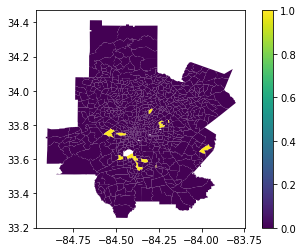

There are  5 census tract with NaN as data
There are  16 Ongoing Displacement - Churn CT


In [105]:
print('ONGOING DISPLACEMENT - CHURN')
ax = data.plot(color = 'white')
ax = data[~data['OD_churn'].isna()].plot(ax = ax, column = 'OD_churn', legend = True)
plt.show()
print('There are ', data['OD_churn'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['OD_churn']==1).sum()), 'Ongoing Displacement - Churn CT')

ONGOING DISPLACEMENT - LOSS


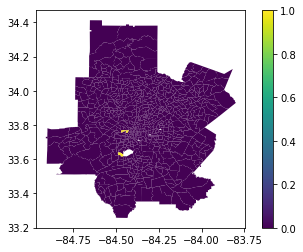

There are  5 census tract with NaN as data
There are  3 Ongoing Displacement - Loss CT


In [106]:
print('ONGOING DISPLACEMENT - LOSS')
ax = data.plot(color = 'white')
ax = data[~data['OD_loss'].isna()].plot(ax = ax, column = 'OD_loss', legend = True)
plt.show()
print('There are ', data['OD_loss'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['OD_loss']==1).sum()), 'Ongoing Displacement - Loss CT')

ONGOING DISPLACEMENT


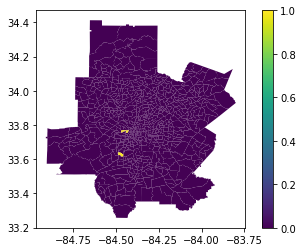

There are  0 census tract with NaN as data
There are  3 Ongoing Displacement CT


In [107]:
print('ONGOING DISPLACEMENT')
ax = data.plot(color = 'white')
ax = data[~data['OD'].isna()].plot(ax = ax, column = 'OD', legend = True)
plt.show()
print('There are ', data['OD'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['OD']==1).sum()), 'Ongoing Displacement CT')

#### Early/Ongoing Gentrification

In [108]:
###************* Early/ongoing gentrification **************
### ****EOG ****
df['EOG'] = 0
df['EOG'] = np.where((df['pop00flag']==1)&
                    ((df['low_pdmt_55cut_80120_medhhinc']==1)|(df['mix_low_55cut_80120_medhhinc']==1))&
                     (df['per_limove_17']<df['per_limove_10'])&                     
                    ((df['lmh_flag_new_encoded'] == 1)|(df['lmh_flag_new_encoded'] == 2)|
                     (df['lmh_flag_new_encoded'] == 3)|(df['lmh_flag_new_encoded'] == 4))&
                    ((df['aff_change_cat_full_encoded'] == 3)|(df['aff_change_cat_full_encoded'] == 4)|
                     (df['aff_change_cat_full_encoded'] == 7)|(df['aff_change_cat_full_encoded'] == 8)|
                     (df['aff_change_cat_full_encoded'] == 11)|(df['aff_change_cat_full_encoded'] == 12)|
                     (df['aff_change_cat_full_encoded'] == 15)|(df['aff_change_cat_full_encoded'] == 16)|
                     (df['ab_50pct_ch'] == 1))&
                     ((df['gent_90_00']==1)|(df['gent_00_17']==1)), 1, 0)

df['EOG'] = np.where((df['pop00flag'].isna())|
                     (df['low_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['mix_low_55cut_80120_medhhinc'].isna())|
                     (df['per_limove_17'].isna())|
                     (df['per_limove_10'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['aff_change_cat_full_encoded'].isna())|
                     (df['gent_90_00'].isna())|
                     (df['gent_00_17'].isna())|
                     (df['ab_50pct_ch'].isna()), np.nan, df['EOG'])

# replace EOG=1 if A==1 & (B==1 |C==1) & D<E & (F==1| G==2 | H==3 | I==4) & (J==3|  K==4| L==7| M==8 | N==11| E==12| F==15| G==16| ab_50pct_ch==1)
#             & (gent_90_00==1 | gent_00_17==1)

EARLY/ONGOING GENTRIFICATION


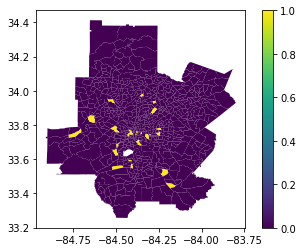

There are  6 census tract with NaN as data
There are  31 Early/Ongoing Gentrification CT


In [109]:
print('EARLY/ONGOING GENTRIFICATION')
ax = data.plot(color = 'white')
ax = data[~data['EOG'].isna()].plot(ax = ax, column = 'EOG', legend = True)
plt.show()
print('There are ', data['EOG'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['EOG']==1).sum()), 'Early/Ongoing Gentrification CT')

#### Stable/Low-Income

In [110]:
### Original stata version
# df = data

# df['SLI'] = 0
# df['SLI'] = np.where((df['pop00flag'] == 1)&
#                      ((df['low_pdmt_55cut_80120_medhhinc_00'] == 1)|(df['mix_low_55cut_80120_medhhinc_00'] == 1))&
#                      ((df['low_pdmt_55cut_80120_medhhinc'] == 1)|(df['mix_low_55cut_80120_medhhinc'] == 1))&
#                       (df['aboverm_pct_recentmovein2010'] == 0)&  ### Stata code had 'var == 1'
#                      ((df['lmh_flag_new_encoded'] == 1)|(df['lmh_flag_new_encoded'] == 2))&
#                      ((df['aff_change_cat_full_encoded'] == 1)|(df['aff_change_cat_full_encoded'] == 2)|
#                      (df['aff_change_cat_full_encoded'] == 5)|(df['aff_change_cat_full_encoded'] == 6)), 1, 0)

# df['SLI'] = np.where((df['pop00flag'].isna())|
#                     (df['low_pdmt_55cut_80120_medhhinc_00'].isna())|
#                     (df['mix_low_55cut_80120_medhhinc_00'].isna())|
#                     (df['low_pdmt_55cut_80120_medhhinc'].isna())|
#                     (df['mix_low_55cut_80120_medhhinc'].isna())|
#                     (df['aboverm_pct_recentmovein2010'].isna())|
#                     (df['lmh_flag_new_encoded'].isna())|
#                     (df['aff_change_cat_full_encoded'].isna()), np.nan, df['SLI'])

### New version
df['SLI'] = 0
df['SLI'] = np.where((df['pop00flag'] == 1)&
                     ((df['low_pdmt_55cut_80120_medhhinc'] == 1)|(df['mix_low_55cut_80120_medhhinc'] == 1))&
                     (df['OD']!=1) & (df['ARG']!=1) *(df['EOG']!=1), 1, 0)

C:\Users\Gaby\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


STABLE LOW INCOME TRACTS


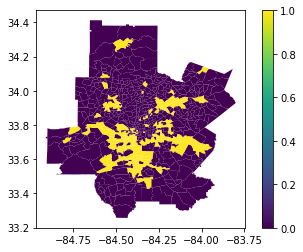

There are  0 census tract with NaN as data
There are  211 Stable Low Income CT


In [111]:
print('STABLE LOW INCOME TRACTS')
ax = data.plot(color = 'white')
ax = data[~data['SLI'].isna()].plot(ax = ax, column = 'SLI', legend = True)
plt.show()
print('There are ', data['SLI'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['SLI']==1).sum()), 'Stable Low Income CT')

LOW INCOME TRACT - CLASSIFICATION


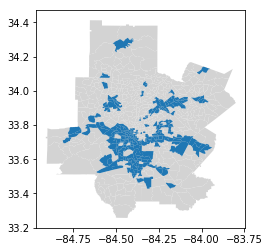

There are  0 census tract with NaN as data
There are  211 Stable Low Income CT


In [112]:
print('LOW INCOME TRACT - CLASSIFICATION')
ax = data.plot(color = 'lightgrey')
LI_ML_income = data[(data['low_pdmt_55cut_80120_medhhinc']==1) | (data['mix_low_55cut_80120_medhhinc']==1)]
LI_ML_income.plot(ax = ax)
# ax = data[].plot(color = 'white')
# ax = data[~data['SLI'].isna()].plot(ax = ax, column = 'SLI', legend = True)
plt.show()
print('There are ', data['SLI'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['SLI']==1).sum()), 'Stable Low Income CT')

#### Stable/Advanced Exclusive

In [113]:
### ********* Stable/advanced exclusive *************

df['SAE'] = 0
df['SAE'] = np.where((df['pop00flag']==1)&
                     (df['high_pdmt_55cut_80120_medhhinc'] == 1)&
                     (df['high_pdmt_55cut_80120_00'] == 1)&                 
                    ((df['lmh_flag_new_encoded'] == 5)|(df['lmh_flag_new_encoded'] == 6))&
                    ((df['aff_change_cat_full_encoded'] == 18)|(df['aff_change_cat_full_encoded'] == 19)|
                     (df['aff_change_cat_full_encoded'] == 20)), 1, 0)

df['SAE'] = np.where((df['pop00flag'].isna())|
                     (df['high_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['high_pdmt_55cut_80120_00'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['aff_change_cat_full_encoded'].isna()), np.nan, df['SAE'])

# replace SAE=1 if A==1 & (A==1) & (B==1) & (C==5| D==6)& (E==18 | F==19 | G==20)

#### Advanced Gentrification

In [114]:
### ************* Advanced gentrification **************

df['AdvG'] = 0
df['AdvG'] = np.where((df['pop00flag']==1)&
                    ((df['mod_pdmt_55cut_80120_medhhinc'] == 1)|(df['high_pdmt_55cut_80120_medhhinc'] == 1)|
                     (df['mix_mod_55cut_80120_medhhinc'] == 1)|(df['mix_high_55cut_80120_medhhinc'] == 1))&                    
                    ((df['lmh_flag_new_encoded'] == 3)|(df['lmh_flag_new_encoded'] == 4)|
                     (df['lmh_flag_new_encoded'] == 5)|(df['lmh_flag_new_encoded'] == 6))&
                    ((df['aff_change_cat_full_encoded'] == 10)|(df['aff_change_cat_full_encoded'] == 11)|
                     (df['aff_change_cat_full_encoded'] == 14)|(df['aff_change_cat_full_encoded'] == 15)|
                     (df['aff_change_cat_full_encoded'] == 18)|(df['aff_change_cat_full_encoded'] == 19)|
                     (df['aff_change_cat_full_encoded'] == 22)|(df['aff_change_cat_full_encoded'] == 23))&
                     ((df['gent_90_00']==1)|(df['gent_00_17']==1)), 1, 0)

df['AdvG'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['high_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['mix_mod_55cut_80120_medhhinc'].isna())|
                     (df['mix_high_55cut_80120_medhhinc'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['aff_change_cat_full_encoded'].isna())|
                     (df['gent_90_00'].isna())|
                     (df['gent_00_17'].isna()), np.nan, df['AdvG'])

df['AdvG'] = np.where((df['AdvG'] == 1)&(df['SAE']==1), 0, df['AdvG']) ### This is to account for double classification

# replace AdvG=1 if A==1 & (B==1|C==1|D==1|E==1) & (F==3| G==4| H==5| I==6) &
#                 (J==10 | K==11 | L==14| M==15| N==18 |O==19 |P==22|Q==23) & (R==1 | S==1)

In [115]:
df[(df['gent_90_00']==0)|(df['gent_00_17']==0)].count()

FIPS                       730
COUNTYFP                   730
geometry                   730
real_hinc_90               730
real_hinc_00               730
hinc_17                    727
regmedian_income90         730
vli_90                     730
li_90                      730
mi1990                     730
hmi1990                    730
hi1990                     730
vhi1990                    730
vli_00                     730
li_00                      730
mi2000                     730
hmi2000                    730
hi2000                     730
vhi2000                    730
vli_17                     727
li_17                      727
mi2017                     727
hmi2017                    727
hi2017                     727
vhi2017                    727
pop_17                     730
pop_17_se                  730
nhwhite_17                 730
hh_17                      730
hinc_17_se                 727
                          ... 
vul00_1                    730
vul00_2 

ADVANCED GENTRIFICATION


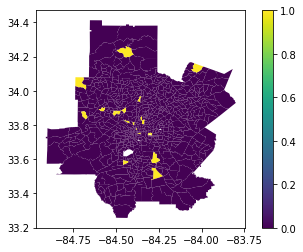

There are  6 census tract with NaN as data
There are  21 Advanced Gentrification CT


In [116]:
print('ADVANCED GENTRIFICATION')
ax = data.plot(color = 'white')
ax = data[~data['AdvG'].isna()].plot(ax = ax, column = 'AdvG', legend = True)
plt.show()
print('There are ', data['AdvG'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['AdvG']==1).sum()), 'Advanced Gentrification CT')

#### Stable Moderate/Mixed Income

In [117]:
### ************* Stable moderate/mixed income *************
###Has to come after the other high income categories

#### At Risk of Becoming Exclusive

In [118]:
### *********** At risk of becoming exclusive *************

### Risk factors first

df['ARE_risk_factors_1'] = (df['aboverm_per_units_pre50_17'].fillna(0) +
                            df['aboverm_per_col_17'].fillna(0) + df['exclusive_tract'].fillna(0))
df['ARE_risk_factors_0'] = (df['presence_ph_LIHTC']==0).astype('int') + (df['aboverm_per_nonwhite_17']==0).astype('int')

### check where the variable for per_nonwhite_17 came from originally and that we have it in the merged dataset!!
### per_nonwhite_17 is in dataset and I will check where it came from  --- ?

df['ARE_risk_factors'] = df['ARE_risk_factors_1'] + df['ARE_risk_factors_0']

### This seems like a weird way to code the data
df['ARE_risks_missings'] = (df['aboverm_per_units_pre50_17'].isna().astype('int'))+ \
                                (df['aboverm_per_col_17'].isna().astype('int'))+ \
                                (df['exclusive_tract'].isna().astype('int'))+ \
                                (df['presence_ph_LIHTC'].isna().astype('int'))+ \
                                (df['aboverm_per_nonwhite_17'].isna().astype('int'))

df['ARE_risk_factors'] = np.where(df['ARE_risks_missings']>2, np.nan, df['ARE_risk_factors'])

df['ARE_risk_factors'] = np.where((df['ARE_risks_missings']==2)|(df['ARE_risk_factors']>=2), 1, df['ARE_risk_factors'])
df['ARE_risk_factors'] = np.where((df['ARE_risks_missings']==1)|(df['ARE_risk_factors']==1), 0, df['ARE_risk_factors'])
df['ARE_risk_factors'] = np.where((df['ARE_risks_missings']==1)|(df['ARE_risk_factors']>=2), 1, df['ARE_risk_factors'])
df['ARE_risk_factors'] = np.where((df['ARE_risks_missings']==0)|(df['ARE_risk_factors']==1), 0, df['ARE_risk_factors'])
df['ARE_risk_factors'] = np.where((df['ARE_risks_missings']==0)|(df['ARE_risk_factors']>=2), 1, df['ARE_risk_factors'])

print(df['ARE_risk_factors'].describe())


### Computes clasification
df['ARE'] = 0
df['ARE'] = np.where((df['pop00flag']==1)&
                    ((df['mod_pdmt_55cut_80120_medhhinc'] == 1)|(df['high_pdmt_55cut_80120_medhhinc'] == 1)|
                     (df['mix_mod_55cut_80120_medhhinc'] == 1)|(df['mix_high_55cut_80120_medhhinc'] == 1))&                   
                    ((df['lmh_flag_new_encoded'] == 3)|(df['lmh_flag_new_encoded'] == 4)|
                     (df['lmh_flag_new_encoded'] == 6))&
                    ((df['aff_change_cat_full_encoded'] == 10)|(df['aff_change_cat_full_encoded'] == 11)|
                     (df['aff_change_cat_full_encoded'] == 14)|(df['aff_change_cat_full_encoded'] == 15)|
                     (df['aff_change_cat_full_encoded'] == 22)|(df['aff_change_cat_full_encoded'] == 23))&
                     (df['ARE_risk_factors']==1), 1, 0)

df['ARE'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['high_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['mix_mod_55cut_80120_medhhinc'].isna())|
                     (df['mix_high_55cut_80120_medhhinc'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['aff_change_cat_full_encoded'].isna())|
                     (df['ARE_risk_factors'].isna()), np.nan, df['ARE'])

# replace ARE=1 if A==1 & (B==1|C==1|C==1|D==1) & (E==3 | F==4| G==6) & (H==10|I==11|J==14|K==15|L==22|M==23) & ARE_risk_factors==1


count    734.000000
mean       0.034060
std        0.181507
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: ARE_risk_factors, dtype: float64


AT RISK OF BECOMING EXCLUSIVE


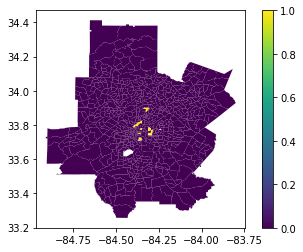

There are  5 census tract with NaN as data
There are  9 At Risk of Exclusive CT


In [119]:
print('AT RISK OF BECOMING EXCLUSIVE')
ax = data.plot(color = 'white')
ax = data[~data['ARE'].isna()].plot(ax = ax, column = 'ARE', legend = True)
plt.show()
print('There are ', data['ARE'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['ARE']==1).sum()), 'At Risk of Exclusive CT')

#### Becoming Exclusive

In [120]:
### *********** Becoming exclusive *************
df['BE'] = 0
df['BE'] = np.where((df['pop00flag']==1)&
                    ((df['mod_pdmt_55cut_80120_medhhinc'] == 1)|(df['mix_mod_55cut_80120_medhhinc'] == 1)|
                     (df['mix_high_55cut_80120_medhhinc'] == 1))&                   
                    ((df['lmh_flag_new_encoded'] == 3)|(df['lmh_flag_new_encoded'] == 4)|
                     (df['lmh_flag_new_encoded'] == 5)|(df['lmh_flag_new_encoded'] == 6))&
                    ((df['aff_change_cat_full_encoded'] == 12)|(df['aff_change_cat_full_encoded'] == 16)|
                     (df['aff_change_cat_full_encoded'] == 20)|(df['aff_change_cat_full_encoded'] == 24))&
                     (df['all_li_count_17']<df['all_li_count_00'])&
                     (df['per_limove_17']<df['per_limove_10'])&
                     (df['real_hinc_17']>df['real_hinc_00']), 1, 0)

df['BE'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['mix_mod_55cut_80120_medhhinc'].isna())|
                     (df['mix_high_55cut_80120_medhhinc'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['all_li_count_17'].isna())|
                     (df['all_li_count_00'].isna())|
                     (df['per_limove_17'].isna())|
                     (df['per_limove_10'].isna())|
                     (df['real_hinc_17'].isna())|
                     (df['real_hinc_00'].isna()), np.nan, df['BE'])

# replace BE=1 if A==1 & (B==1|C==1|D==1) & (E==3| F==4|G==5 | H==6)& (I==12| J==16 | K==20| L==24) & M<N & O<P & Q>R

#### Stable Moderate/Mixed Income

In [121]:
### OLD version

# ### ********* Stable moderate/mixed income *************
# ## Note - this has to come after the typologies involving exclusion, since it relies on those definitions

# df['SMMI'] = 0
# df['SMMI'] = np.where((df['pop00flag']==1)&
#                      ((df['mod_pdmt_55cut_80120_medhhinc_00'] == 1)|(df['mix_mod_55cut_80120_medhhinc_00'] == 1)&
#                       (df['mix_high_55cut_80120_medhhinc_00'] == 1))&
#                      ((df['mod_pdmt_55cut_80120_medhhinc'] == 1)|(df['mix_mod_55cut_80120_medhhinc'] == 1)|
#                       (df['mix_high_55cut_80120_medhhinc'] == 1))&             
#                      ((df['lmh_flag_new_encoded'] == 3)|(df['lmh_flag_new_encoded'] == 4)|
#                       (df['lmh_flag_new_encoded'] == 6))&   
#                      ((df['aff_change_cat_full_encoded'] == 10)|(df['aff_change_cat_full_encoded'] == 11)|
#                       (df['aff_change_cat_full_encoded'] == 14)|(df['aff_change_cat_full_encoded'] == 15)|
#                       (df['aff_change_cat_full_encoded'] == 22)|(df['aff_change_cat_full_encoded'] == 23))&
#                      (df['ARE']==0)&(df['BE']==0)&(df['SAE']==0), 1, 0)


# df['SMMI'] = np.where((df['pop00flag'].isna())|
#                       (df['mod_pdmt_55cut_80120_medhhinc_00'].isna())|
#                       (df['mix_mod_55cut_80120_medhhinc_00'].isna())|
#                       (df['mix_high_55cut_80120_medhhinc_00'].isna())|
#                       (df['mod_pdmt_55cut_80120_medhhinc'].isna())|
#                       (df['mix_mod_55cut_80120_medhhinc'].isna())|
#                       (df['mix_high_55cut_80120_medhhinc'].isna())|
#                       (df['lmh_flag_new_encoded'].isna())|
#                       (df['aff_change_cat_full_encoded'].isna())|
#                       (df['ARE'].isna())|
#                       (df['BE'].isna())|
#                       (df['SAE'].isna()), np.nan, df['SMMI'])

# # replace SMMI=1 if A==1 & (A==1 | B==1 | C==1 ) & (D==1|E==1|F==1) & (G==3| H==4| I==6)& (J==10|K==11|L==14|M==15|N==22|O==23) & P==0 & Q==0 & R==0
# #* 8/16/19: this currently includes high income classification for 2000 and 2017, but does not include high for affordability or market change variables...


### New Version - Override
df['SMMI'] = 0
df['SMMI'] = np.where((df['pop00flag']==1)&
                     ((df['mod_pdmt_55cut_80120_medhhinc'] == 1)|(df['mix_mod_55cut_80120_medhhinc'] == 1)|
                      (df['mix_high_55cut_80120_medhhinc'] == 1)|(df['high_pdmt_55cut_80120_medhhinc'] == 1))&             
                     (df['ARE']==0)&(df['BE']==0)&(df['SAE']==0)&(df['AdvG']==0), 1, 0)

## Create Typology variables from all the dummies

In [122]:
df['double_counted'] = (df['SLI'].fillna(0) + df['OD'].fillna(0) + df['ARG'].fillna(0) + df['EOG'].fillna(0) +
                       df['AdvG'].fillna(0) + df['ARE'].fillna(0) + df['BE'].fillna(0) + df['SAE'] + df['SMMI'])
    
df['typology'] = np.nan
df['typology'] = np.where(df['SLI'] == 1, 1, df['typology'])
df['typology'] = np.where(df['OD'] == 1, 2, df['typology'])
df['typology'] = np.where(df['ARG'] == 1, 3, df['typology'])
df['typology'] = np.where(df['EOG'] == 1, 4, df['typology'])
df['typology'] = np.where(df['AdvG'] == 1, 5, df['typology'])
df['typology'] = np.where(df['SMMI'] == 1, 6, df['typology'])
df['typology'] = np.where(df['ARE'] == 1, 7, df['typology'])
df['typology'] = np.where(df['BE'] == 1, 8, df['typology'])
df['typology'] = np.where(df['SAE'] == 1, 9, df['typology'])
df['typology'] = np.where(df['double_counted']>1, 99, df['typology'])

# label def typology_name 0 "No typology applied"  1 "Stable Low Income" 2 "Ongoing Displacement" 3 "At Risk of Gentrification" 4 "Early/ Ongoing Gentrification" 5 "Advanced Gentrification" 6 "Stable Middle/Mixed Income" 7 "At Risk of Exclusion" 8 "Becoming Exclusive" 9 "Stable Advanced Exclusion" 99 "Multiple typologies applied"

#### Double Classification

In [123]:
cat_i = list()

# df = data[(data['low_pdmt_55cut_80120_medhhinc'] == 1)|(df['mix_low_55cut_80120_medhhinc'] == 1)].reset_index (drop=True)
df = data
for i in range (0, len (df)):
    categories = list()
    if df['SLI'][i] == 1:
        categories.append('SLI')
    if df['OD'][i] == 1:
        categories.append('OD')
    if df['ARG'][i] == 1:
        categories.append('ARG')
    if df['EOG'][i] == 1:
        categories.append('EOG')
    if df['AdvG'][i] == 1:
        categories.append('AdvG')
    if df['SMMI'][i] == 1:
        categories.append('SMMI')
    if df['ARE'][i] == 1:
        categories.append('ARE')
    if df['BE'][i] == 1:
        categories.append('BE')
    if df['SAE'][i] == 1:
        categories.append('SAE')
    cat_i.append(str(categories))
    
df['typ_cat'] = cat_i

In [124]:
df.groupby('typ_cat').count()['FIPS']

typ_cat
['ARE']              7
['ARG']              4
['AdvG', 'ARE']      2
['AdvG']            19
['BE']               5
['EOG']             31
['OD']               3
['SAE']             21
['SLI']            211
['SMMI']           430
[]                   5
Name: FIPS, dtype: int64

In [125]:
print(len(df[(df['typ_cat']== '[]')]))
print(len(df[(df['typ_cat']== '[]')&(df['BE'].isna())]))

5
5


In [126]:
comm_areas = gpd.read_file('Input_Files/Chicago/shp/commareas_chicago.shp')
comm_areas.head()

,community,perimeter,comarea_,comarea_id,area_numbe,cartodb_id,area,shape_area,shape_len,created_at,updated_at,area_num_1,geometry
0,KENWOOD,0.0,0,0,39,5,0.0,2.907174e+07,23325.167906,2015-06-19,2015-06-19,39,POLYGON ((-87.59215283878491 41.81692934706857...
1,LINCOLN SQUARE,0.0,0,0,4,6,0.0,7.135233e+07,36624.603085,2015-06-19,2015-06-19,4,POLYGON ((-87.67440756779521 41.97610340524936...
2,HYDE PARK,0.0,0,0,41,8,0.0,4.510538e+07,29746.708202,2015-06-19,2015-06-19,41,POLYGON ((-87.58037662084507 41.80252502285023...
3,WOODLAWN,0.0,0,0,42,9,0.0,5.781518e+07,46936.959244,2015-06-19,2015-06-19,42,"POLYGON ((-87.57714456890425 41.7861464109302,..."
4,ROGERS PARK,0.0,0,0,1,10,0.0,5.125990e+07,34052.397576,2015-06-19,2015-06-19,1,POLYGON ((-87.65455590024227 41.99816615053946...


In [127]:
df['BE'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_55cut_80120_medhhinc'].isna())|
                     (df['mix_mod_55cut_80120_medhhinc'].isna())|
                     (df['mix_high_55cut_80120_medhhinc'].isna())|
                     (df['lmh_flag_new_encoded'].isna())|
                     (df['all_li_count_17'].isna())|
                     (df['all_li_count_00'].isna())|
                     (df['per_limove_17'].isna())|
                     (df['per_limove_10'].isna())|
                     (df['real_hinc_17'].isna())|
                     (df['real_hinc_00'].isna()), np.nan, df['BE'])

In [128]:
len(df[df['per_limove_17'].isna()])

3

In [129]:
df.groupby('typology').count()['FIPS']

typology
1.0     211
2.0       3
3.0       4
4.0      31
5.0      19
6.0     430
7.0       7
8.0       5
9.0      21
99.0      2
Name: FIPS, dtype: int64

TYPOLOGIES


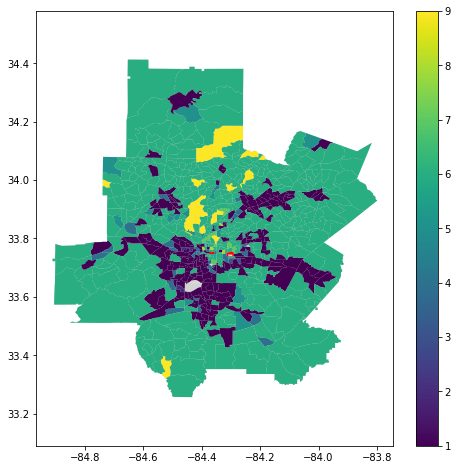

There are  5 census tract with NaN as data


In [130]:
print('TYPOLOGIES')

f, ax = plt.subplots(1, figsize=(8, 8))
data.plot(ax=ax, color = 'lightgrey')
lims = plt.axis('equal')
data[(~data['typology'].isna())&(data['typology']!=99)].plot(ax = ax, column = 'typology', legend = True)
data[data['typology']==99].plot(ax =ax, color = 'red')
plt.show()
print('There are ', data['typology'].isna().sum(), 'census tract with NaN as data')